<a href="https://colab.research.google.com/github/lucianosilva-github/paradigmas/blob/main/PARADIGMAS%20-%20AULA%2013%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LINGUAGENS E PARADIGMAS - AULA 13**

**Prof. Luciano Silva**

**OBJETIVOS DA AULA:**

*   Continuar o processo de compilação de linguagens imperativas (comando de repetição while)
*   Produzir uma gramática para comando de repetição while
*   Gerar código para o comando while


In [1]:
!pip install rply

**GRAMÁTICA DE COMANDO CONDICIONAL IF-ELSE**

Na nossa última aula, implementamos uma versão corrigida do comando condicional if-else, capaz de tratar o problema de **dangling else**. A gramática segue abaixo:







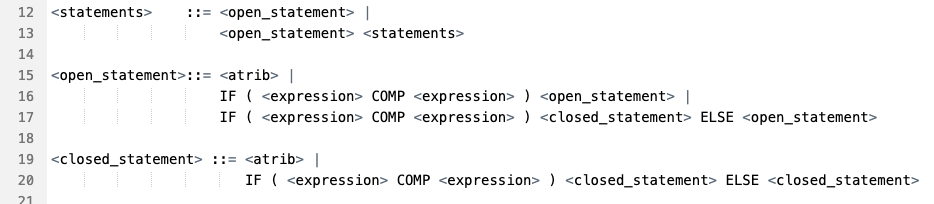

In [2]:
from rply import LexerGenerator

lg = LexerGenerator()

lg.add('NUMBER', r'\d+')
lg.add('PLUS', r'\+')
lg.add('MINUS', r'-')
lg.add('MUL', r'\*')
lg.add('DIV', r'/')
lg.add('OPEN_PARENS', r'\(')
lg.add('CLOSE_PARENS', r'\)')

lg.add('INT', r'int')
lg.add('STRING', r'string')
lg.add('IF', r'if')
lg.add('ELSE', r'else')

lg.add('ID', r'[a-zA-z][a-zA-z0-9]*')
lg.add('COMP','==')
lg.add('COMP','!=')
lg.add('COMP','>=')
lg.add('COMP','>')
lg.add('COMP','<=')
lg.add('COMP','<')

lg.add('EQUALS', r'=')
lg.add('SEMICOL', r';')

lg.ignore('\s+')

lexer = lg.build()

* Classes dos nós da árvore sintática, já com o método accept para receber os visitors:

In [3]:
#ÁRVORE SINTÁTICA PREPARADA PARA RECEBER VISITORS

from rply.token import BaseBox

class Prog(BaseBox):
    def __init__(self, decls,stmts):
        self.decls = decls
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_prog(self)

class VarDecls(BaseBox):
    def __init__(self, decl,decls):
        self.decl = decl
        self.decls = decls

    def accept(self, visitor):
        visitor.visit_vardecls(self)

class VarDecl(BaseBox):
    def __init__(self, id,tp):
        self.id = id
        self.tp = tp


    def accept(self, visitor):
        visitor.visit_vardecl(self)

class Statements(BaseBox):
    def __init__(self, stmt,stmts):
        self.stmt = stmt
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_statements(self)

class Statement(BaseBox):
    def __init__(self,cmd):
        self.cmd = cmd

    def accept(self, visitor):
        visitor.visit_statement(self)

class Atrib(BaseBox):
    def __init__(self, id,expr):
        self.id = id
        self.expr = expr

    def accept(self, visitor):
        visitor.visit_atrib(self)

class IfElse(BaseBox):
    def __init__(self, expr1, comp, expr2, ie1,ie2):
        self.expr1=expr1
        self.comp = comp
        self.expr2=expr2
        self.ie1=ie1
        self.ie2=ie2

    def accept(self, visitor):
        visitor.visit_ifelse(self)


class Expr(BaseBox):
    def accept(self, visitor):
        method_name = 'visit_{}'.format(self.__class__.__name__.lower())
        visit = getattr(visitor, method_name)
        visit(self)

class Id(Expr):
    def __init__(self, value):
        self.value = value

class Number(Expr):
    def __init__(self, value):
        self.value = value


class BinaryOp(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOp):
  pass


class Sub(BinaryOp):
  pass


class Mul(BinaryOp):
  pass


class Div(BinaryOp):
  pass


* Implementação do analisador sintático:

In [4]:
#ANALISADOR SINTÁTICO

from rply import ParserGenerator

pg = ParserGenerator(
    # A list of all token names, accepted by the lexer.
    ['NUMBER', 'OPEN_PARENS', 'CLOSE_PARENS',
     'PLUS', 'MINUS', 'MUL', 'DIV', 'INT', 'STRING', 'ID','SEMICOL',
     'EQUALS','COMP','IF','ELSE'
    ],
    # A list of precedence rules with ascending precedence, to
    # disambiguate ambiguous production rules.
    precedence=[
        ('left', ['PLUS', 'MINUS']),
        ('left', ['MUL', 'DIV'])
    ]
)

@pg.production('prog : vardecls statements')
def prog(p):
    return Prog(p[0],p[1])

@pg.production('vardecls : vardecl')
def vardecls(p):
    return VarDecls(p[0],None)

@pg.production('vardecls : vardecl vardecls')
def vardecls(p):
    return VarDecls(p[0],p[1])

@pg.production('vardecl : STRING ID SEMICOL')
def vardecl_string(p):
    return VarDecl(p[1].getstr(), "string")

@pg.production('vardecl : INT ID SEMICOL')
def vardecl_int(p):
    return VarDecl(p[1].getstr(), "int")

@pg.production('statements : openstatement')
def statement_statements(p):
    return Statements(p[0],None)

@pg.production('statements : openstatement statements')
def statement_statements(p):
    return Statements(p[0],p[1])

@pg.production('openstatement : atrib')
def statement_atrib(p):
    return Statement(p[0])

@pg.production('openstatement : IF OPEN_PARENS expression COMP expression CLOSE_PARENS openstatement')
def expression_ifelse1(p):
    return IfElse (p[2],p[3],p[4],p[6],None)


@pg.production('openstatement : IF OPEN_PARENS expression COMP expression CLOSE_PARENS closedstatement ELSE openstatement')
def expression_ifelse1(p):
    return IfElse (p[2],p[3],p[4],p[6],p[8])


@pg.production('closedstatement : atrib')
def statement_atrib(p):
    return Statement(p[0])


@pg.production('closedstatement : IF OPEN_PARENS expression COMP expression CLOSE_PARENS closedstatement ELSE closedstatement')
def expression_ifelse1(p):
    return IfElse (p[2],p[3],p[4],p[6],p[8])

@pg.production('atrib : ID EQUALS expression SEMICOL')
def atrib(p):
    return Atrib(p[0].getstr(),p[2])

@pg.production('expression : ID')
def expression_id(p):
    return Id(p[0].getstr())

@pg.production('expression : NUMBER')
def expression_number(p):
    return Number(int(p[0].getstr()))

@pg.production('expression : OPEN_PARENS expression CLOSE_PARENS')
def expression_parens(p):
    return p[1]

@pg.production('expression : expression PLUS expression')
@pg.production('expression : expression MINUS expression')
@pg.production('expression : expression MUL expression')
@pg.production('expression : expression DIV expression')
def expression_binop(p):
    left = p[0]
    right = p[2]
    if p[1].gettokentype() == 'PLUS':
        return Add(left, right)
    elif p[1].gettokentype() == 'MINUS':
        return Sub(left, right)
    elif p[1].gettokentype() == 'MUL':
        return Mul(left, right)
    elif p[1].gettokentype() == 'DIV':
        return Div(left, right)
    else:
        raise AssertionError('Oops, this should not be possible!')

parser = pg.build()

In [5]:
# VISITOR PARA TABELA DE SÍMBOLOS

ST={}

class Visitor(object):
  pass

class SymbolTable(Visitor):
    def visit_prog(self, prog):
        prog.decls.accept(self)

    def visit_vardecls(self, d):
        d.decl.accept(self)
        if d.decls!=None:
          d.decls.accept(self)

    def visit_vardecl(self, d):
        ST[d.id]=d.tp


In [6]:
arvore=parser.parse(lexer.lex('int x;int y; x=3;if(x<3) if (x>=2) y=4; else y=5; else y=6;'))
arvore.accept(SymbolTable())
print(ST)

{'x': 'int', 'y': 'int'}


In [7]:
#VISITOR PARA DECORAR TIPOS

class Decorator(Visitor):

    def visit_prog(self, i):
        i.stmts.accept(self)

    def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)

    def visit_statement(self, d):
        d.cmd.accept(self)

    def visit_atrib(self, i):
        if i.id in ST:
          i.decor_type=ST[i.id]
        else:
          raise AssertionError('id not declared')
        i.expr.accept(self)

    def visit_ifelse(self, i):
        i.expr1.accept(self)
        i.expr2.accept(self)
        i.ie1.accept(self)
        if i.ie2!=None:
          i.ie2.accept(self)

    def visit_id(self, i):
        if i.value in ST:
          i.decor_type=ST[i.value]
        else:
          raise AssertionError('id not declared')


    def visit_number(self, i):
        i.decor_type="int"


    def visit_add(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"


    def visit_sub(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_mul(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_div(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"



In [9]:
arvore=parser.parse(lexer.lex('int x;int y; x=3;if(x<3) if (x>=2) y=4; else y=5;'))
arvore.accept(SymbolTable())
arvore.accept(Decorator())

In [10]:
# VISITOR - TYPE VERIFIER

class TypeVerifier(Visitor):

    def visit_prog(self, i):
        i.stmts.accept(self)

    def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)

    def visit_statement(self, d):
        d.cmd.accept(self)

    def visit_atrib(self, i):
        if i.decor_type!=i.expr.decor_type:
          raise AssertionError('type error')

    def visit_ifelse(self, i):
        if i.expr1.decor_type!=i.expr2.decor_type:
          raise AssertionError('type error')


In [11]:
arvore=parser.parse(lexer.lex('int x;int y; x=3;if(x<3) if (x>=2) y=4; else y=5; else y=6;'))
arvore.accept(SymbolTable())
arvore.accept(Decorator())
arvore.accept(TypeVerifier())

**GERAÇÃO DE CÓDIGO PARA COMANDOS CONDICIONAIS**

Para a geração de código de comandos condicionais vamos usar os operadores de comparação:

* **EQL** (Equals) OPR 0 8
* **NEQ** (Not equals) OPR 0 9
* **LSS** (Less than) OPR 0 10
* **LEQ** (Less equals) OPR 0 11
* **GTR** (Greater than) OPR 0 12
* **GEQ** (Greater equals) OPR 0 13

E os operadores de jump (salto):

*   **JMP** (Jump)
*   **JPC** (Conditional Jump)



Vamos analisar um exemplo simples:

if (x>2) y =4

Em P-CODE isto ficaria como:

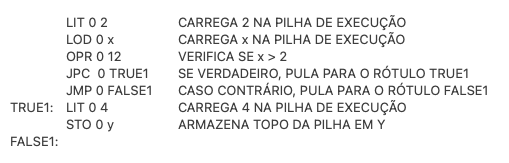


**EXERCÍCIO DA AULA PASSADA**

Implementar um visitor para gerar código intermediário em P-Code para comandos condicionais.

In [23]:
class IntermediateCode(Visitor):

  def __init__(self):
        self.level=0  #nível do if-then-else
        self.comp={"==":"8","!=":"9","<":"10", "<=":"11", ">":"12", ">=":"13" } #códigos dos comparadores


  def visit_prog(self, i):
        i.stmts.accept(self)

  def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)


  def visit_statement(self, d):
        d.cmd.accept(self)

  def visit_atrib(self, i):
        i.expr.accept(self)
        print("sto 0",i.id)

  def visit_ifelse(self, i):
        i.expr2.accept(self) #gera código para expressão 2
        i.expr1.accept(self) #gera código para expressão 1
        print("opr 0 "+self.comp[i.comp.getstr()])  #obtém o código do operador de comparação
        self.level=self.level+1
        print("jpc 0 true"+str(self.level)) # se o resultado da comparação for verdadeiro, pula para o true correspondente
        print("jmp 0 false"+str(self.level))# se o resultado da comparação for falso, pula para o true correspondente
        print("true"+str(self.level)+":") #gera o rótulo da seção true
        i.ie1.accept(self) # gera o código para true
        print("jmp final"+str(self.level)) # pula para o final do bloco if-true-else
        print("false"+str(self.level)+":") #gera o rótulo para a seção false
        if i.ie2!=None:  # se houver else, gera o código
          i.ie2.accept(self)
        print("final"+str(self.level)+":") #gera o rótulo para o final do bloco
        self.level=self.level-1

  def visit_number(self, i):
    print("lit 0 ",i.value)

  def visit_id(self, i):
    print("lod 0 ",i.value)

  def visit_add(self, a):
        a.left.accept(self)
        a.right.accept(self)
        print("opr 0 2")


  def visit_sub(self, a):
        a.left.accept(self)
        a.right.accept(self)
        print("opr 0 3")


  def visit_mul(self, a):
        a.left.accept(self)
        a.right.accept(self)
        print("opr 0 4")


  def visit_div(self, a):
        a.left.accept(self)
        a.right.accept(self)
        print("opr 0 5")


In [24]:
arvore=parser.parse(lexer.lex('int x;int y; x=3;if(x<3) if (x>=2) y=4; else y=5; else y=6;'))
arvore.accept(SymbolTable())
arvore.accept(Decorator())
arvore.accept(TypeVerifier())
arvore.accept(IntermediateCode())

lit 0  3
sto 0 x
lit 0  3
lod 0  x
opr 0 10
jpc 0 true1
jmp 0 false1
true1:
lit 0  2
lod 0  x
opr 0 13
jpc 0 true2
jmp 0 false2
true2:
lit 0  4
sto 0 y
jmp final2
false2:
lit 0  5
sto 0 y
final2:
jmp final1
false1:
lit 0  6
sto 0 y
final1:


Esta saída pode ser melhor visualizada da seguinte forma:

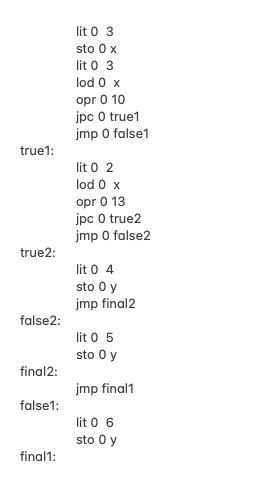

**EXERCÍCIO**

Compare o programa fornecido com o código intermediário e identifique as partes correspondentes.

**COMANDO WHILE**

O comando imperativo **while** é uma abstração do conceito de **loop** em linguagens de programação. Um bloco dentro dentro de um comando while é executado enquanto uma condição é verdadeira, como no exemplo abaixo:


*   x=5
*   **while** (x>0)
  *       x=x-1


Se o programa não for estruturado, isto é, se for permitido usar goto, podemos escrever o comando while como um comando if:

*   x=5
*   loop: **if** (x>0)
      * x=x-1
      * **goto** loop

**EXERCÍCIO**


1.   Modificar a última versão da nossa gramática para acomodar o comando while. Lembre-se que dentro de um while podemos ter atribuições, condicionais e outros loops.
2.   Implementar um analisador léxico para identificar os tokens da gramática modificada.
3. Implementar um analisador sintático para identificar os tokens da gramática modificada.
4. Implementar os visitors para montagem da tabela de símbolos, decorador de tipos, verificador de tipos e gerador de código intermediário para o comando while.



In [ ]:
from rply import LexerGenerator

lg = LexerGenerator()

lg.add('NUMBER', r'\d+')
lg.add('PLUS', r'\+')
lg.add('MINUS', r'-')
lg.add('MUL', r'\*')
lg.add('DIV', r'/')
lg.add('OPEN_PARENS', r'\(')
lg.add('CLOSE_PARENS', r'\)')

lg.add('INT', r'int')
lg.add('STRING', r'string')
lg.add('IF', r'if')
lg.add('ELSE', r'else')
lg.add('FOR', r'for')
#alteracoes comecam aqui
lg.add('WHILE', r'while')
#e terminam aqui

lg.add('ID', r'[a-zA-z][a-zA-z0-9]*')
lg.add('COMP','==')
lg.add('COMP','!=')
lg.add('COMP','>=')
lg.add('COMP','>')
lg.add('COMP','<=')
lg.add('COMP','<')

lg.add('EQUALS', r'=')
lg.add('SEMICOL', r';')

lg.ignore('\s+')

lexer = lg.build()

In [ ]:
from rply.token import BaseBox

class Prog(BaseBox):
    def __init__(self, decls,stmts):
        self.decls = decls
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_prog(self)

class VarDecls(BaseBox):
    def __init__(self, decl,decls):
        self.decl = decl
        self.decls = decls

    def accept(self, visitor):
        visitor.visit_vardecls(self)

class VarDecl(BaseBox):
    def __init__(self, id,tp):
        self.id = id
        self.tp = tp


    def accept(self, visitor):
        visitor.visit_vardecl(self)

class Statements(BaseBox):
    def __init__(self, stmt,stmts):
        self.stmt = stmt
        self.stmts = stmts

    def accept(self, visitor):
        visitor.visit_statements(self)

class Statement(BaseBox):
    def __init__(self,cmd):
        self.cmd = cmd

    def accept(self, visitor):
        visitor.visit_statement(self)

class Atrib(BaseBox):
    def __init__(self, id,expr):
        self.id = id
        self.expr = expr

    def accept(self, visitor):
        visitor.visit_atrib(self)

class IfElse(BaseBox):
    def __init__(self, expr1, comp, expr2, ie1,ie2):
        self.expr1=expr1
        self.comp = comp
        self.expr2=expr2
        self.ie1=ie1
        self.ie2=ie2

    def accept(self, visitor):
        visitor.visit_ifelse(self)

#alteracoes comecam aqui

class While(BaseBox):
    def __init__(self, expr1, comp, expr2, ie1):
        self.expr1=expr1
        self.comp = comp
        self.expr2=expr2
        self.ie1=ie1


    def accept(self, visitor):
        visitor.visit_while(self)

#e terminam aqui

class Expr(BaseBox):
    def accept(self, visitor):
        method_name = 'visit_{}'.format(self.__class__.__name__.lower())
        visit = getattr(visitor, method_name)
        visit(self)

class Id(Expr):
    def __init__(self, value):
        self.value = value

class Number(Expr):
    def __init__(self, value):
        self.value = value


class BinaryOp(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOp):
  pass


class Sub(BinaryOp):
  pass


class Mul(BinaryOp):
  pass


class Div(BinaryOp):
  pass


In [ ]:
from rply import ParserGenerator

pg = ParserGenerator(
    # A list of all token names, accepted by the lexer.
    ['NUMBER', 'OPEN_PARENS', 'CLOSE_PARENS',
     'PLUS', 'MINUS', 'MUL', 'DIV', 'INT', 'STRING', 'ID','SEMICOL',
     'EQUALS','COMP','IF','ELSE', 'WHILE'
    ],
    # A list of precedence rules with ascending precedence, to
    # disambiguate ambiguous production rules.
    precedence=[
        ('left', ['PLUS', 'MINUS']),
        ('left', ['MUL', 'DIV'])
    ]
)

@pg.production('prog : vardecls statements')
def prog(p):
    return Prog(p[0],p[1])

@pg.production('vardecls : vardecl')
def vardecls(p):
    return VarDecls(p[0],None)

@pg.production('vardecls : vardecl vardecls')
def vardecls(p):
    return VarDecls(p[0],p[1])

@pg.production('vardecl : STRING ID SEMICOL')
def vardecl_string(p):
    return VarDecl(p[1].getstr(), "string")

@pg.production('vardecl : INT ID SEMICOL')
def vardecl_int(p):
    return VarDecl(p[1].getstr(), "int")

@pg.production('statements : openstatement')
def statement_statements(p):
    return Statements(p[0],None)

@pg.production('statements : openstatement statements')
def statement_statements(p):
    return Statements(p[0],p[1])

@pg.production('openstatement : atrib')
def statement_atrib(p):
    return Statement(p[0])

@pg.production('openstatement : IF OPEN_PARENS expression COMP expression CLOSE_PARENS openstatement')
def expression_ifelse1(p):
    return IfElse (p[2],p[3],p[4],p[6],None)


@pg.production('openstatement : IF OPEN_PARENS expression COMP expression CLOSE_PARENS closedstatement ELSE openstatement')
def expression_ifelse1(p):
    return IfElse (p[2],p[3],p[4],p[6],p[8])


####
@pg.production('openstatement : WHILE OPEN_PARENS expression COMP expression CLOSE_PARENS openstatement')
def statement_while(p):
    return While (p[2],p[3],p[4],p[6])

@pg.production('closedstatement : WHILE OPEN_PARENS expression COMP expression CLOSE_PARENS closedstatement')
def statement_while(p):
    return While (p[2],p[3],p[4],p[6])

###


@pg.production('closedstatement : atrib')
def statement_atrib(p):
    return Statement(p[0])


@pg.production('closedstatement : IF OPEN_PARENS expression COMP expression CLOSE_PARENS closedstatement ELSE closedstatement')
def expression_ifelse1(p):
    return IfElse (p[2],p[3],p[4],p[6],p[8])

@pg.production('closedstatement : FOR OPEN_PARENS expression COMP expression CLOSE_PARENS closedstatement')
def expression_ifelse1(p):
    return IfElse (p[2],p[3],p[4],p[6],p[8])

@pg.production('atrib : ID EQUALS expression SEMICOL')
def atrib(p):
    return Atrib(p[0].getstr(),p[2])

@pg.production('expression : ID')
def expression_id(p):
    return Id(p[0].getstr())

@pg.production('expression : NUMBER')
def expression_number(p):
    return Number(int(p[0].getstr()))

@pg.production('expression : OPEN_PARENS expression CLOSE_PARENS')
def expression_parens(p):
    return p[1]

@pg.production('expression : expression PLUS expression')
@pg.production('expression : expression MINUS expression')
@pg.production('expression : expression MUL expression')
@pg.production('expression : expression DIV expression')
def expression_binop(p):
    left = p[0]
    right = p[2]
    if p[1].gettokentype() == 'PLUS':
        return Add(left, right)
    elif p[1].gettokentype() == 'MINUS':
        return Sub(left, right)
    elif p[1].gettokentype() == 'MUL':
        return Mul(left, right)
    elif p[1].gettokentype() == 'DIV':
        return Div(left, right)
    else:
        raise AssertionError('Oops, this should not be possible!')

parser = pg.build()

In [ ]:
# VISITOR PARA TABELA DE SÍMBOLOS

ST={}

class Visitor(object):
  pass

class SymbolTable(Visitor):
    def visit_prog(self, prog):
        prog.decls.accept(self)

    def visit_vardecls(self, d):
        d.decl.accept(self)
        if d.decls!=None:
          d.decls.accept(self)

    def visit_vardecl(self, d):
        ST[d.id]=d.tp


In [ ]:
#VISITOR PARA DECORAR TIPOS

class Decorator(Visitor):

    def visit_prog(self, i):
        i.stmts.accept(self)

    def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)

    def visit_statement(self, d):
        d.cmd.accept(self)

    def visit_atrib(self, i):
        if i.id in ST:
          i.decor_type=ST[i.id]
        else:
          raise AssertionError('id not declared')
        i.expr.accept(self)

    def visit_ifelse(self, i):
        i.expr1.accept(self)
        i.expr2.accept(self)
        i.ie1.accept(self)
        if i.ie2!=None:
          i.ie2.accept(self)

  #alteracoes comecam aqui

    def visit_while(self, i):
        i.expr1.accept(self)
        i.expr2.accept(self)
        i.ie1.accept(self)
        
  #e terminam aqui

    def visit_id(self, i):
        if i.value in ST:
          i.decor_type=ST[i.value]
        else:
          raise AssertionError('id not declared')


    def visit_number(self, i):
        i.decor_type="int"


    def visit_add(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"


    def visit_sub(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_mul(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_div(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"



In [ ]:
# VISITOR - TYPE VERIFIER

class TypeVerifier(Visitor):

    def visit_prog(self, i):
        i.stmts.accept(self)

    def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)

    def visit_statement(self, d):
        d.cmd.accept(self)

    def visit_atrib(self, i):
        if i.decor_type!=i.expr.decor_type:
          raise AssertionError('type error')

    def visit_ifelse(self, i):
        if i.expr1.decor_type!=i.expr2.decor_type:
          raise AssertionError('type error')
        
    #alteracoes comecam aqui
    def visit_while(self, i):
        if i.expr1.decor_type!=i.expr2.decor_type:
          raise AssertionError('type error')
    #e terminam aqui


In [ ]:
class IntermediateCode(Visitor):

  def __init__(self):
        self.level=0  #nível do if-then-else
        self.comp={"==":"8","!=":"9","<":"10", "<=":"11", ">":"12", ">=":"13" } #códigos dos comparadores


  def visit_prog(self, i):
        i.stmts.accept(self)

  def visit_statements(self, d):
        d.stmt.accept(self)
        if d.stmts!=None:
          d.stmts.accept(self)


  def visit_statement(self, d):
        d.cmd.accept(self)

  def visit_atrib(self, i):
        i.expr.accept(self)
        print("sto 0",i.id)

  def visit_ifelse(self, i):
        i.expr2.accept(self) #gera código para expressão 2
        i.expr1.accept(self) #gera código para expressão 1
        print("opr 0 "+self.comp[i.comp.getstr()])  #obtém o código do operador de comparação
        self.level=self.level+1
        print("jpc 0 true"+str(self.level)) # se o resultado da comparação for verdadeiro, pula para o true correspondente
        print("jmp 0 false"+str(self.level))# se o resultado da comparação for falso, pula para o true correspondente
        print("true"+str(self.level)+":") #gera o rótulo da seção true
        i.ie1.accept(self) # gera o código para true
        print("jmp final"+str(self.level)) # pula para o final do bloco if-true-else
        print("false"+str(self.level)+":") #gera o rótulo para a seção false
        if i.ie2!=None:  # se houver else, gera o código
          i.ie2.accept(self)
        print("final"+str(self.level)+":") #gera o rótulo para o final do bloco
        self.level=self.level-1

      #alteracoes comecam aqui
  def visit_while(self, i):
        self.loop=self.loop+1
        print("loop"+str(self.loop)+":") #gera o rótulo da seção true
        i.expr2.accept(self) #gera código para expressão 2
        i.expr1.accept(self) #gera código para expressão 1
        print("opr 0 "+self.comp[i.comp.getstr()])  #obtém o código do operador de comparação
        self.level=self.level+1
        print("jpc 0 true"+str(self.level)) # se o resultado da comparação for verdadeiro, pula para o true correspondente
        print("jmp 0 final"+str(self.level))# se o resultado da comparação for falso, pula para o true correspondente
        print("true"+str(self.level)+":") #gera o rótulo da seção true
        i.ie1.accept(self) # gera o código para true
        print("jmp loop"+str(self.loop)) # pula para o início do loop
        print("final"+str(self.level)+":") #gera o rótulo para o final do bloco do loop
        self.level=self.level-1
      
      #e terminam aqui
        

  def visit_number(self, i):
    print("lit 0 ",i.value)

  def visit_id(self, i):
    print("lod 0 ",i.value)

  def visit_add(self, a):
        a.left.accept(self)
        a.right.accept(self)
        print("opr 0 2")


  def visit_sub(self, a):
        a.left.accept(self)
        a.right.accept(self)
        print("opr 0 3")


  def visit_mul(self, a):
        a.left.accept(self)
        a.right.accept(self)
        print("opr 0 4")


  def visit_div(self, a):
        a.left.accept(self)
        a.right.accept(self)
        print("opr 0 5")
